# Project: WeRateDogs Data Wrangling Project

> The dataset that I __wrangled__, analyzed and visualized is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent.

I start this project by importing some modules that may be needed in the course of this project.

In [1]:
# Import modules for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from timeit import default_timer as timer
import tweepy
import seaborn as sns
%matplotlib inline

## Gathering Data

In [2]:
# read the @WeRateDog twitter archive to dataframe
df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# get the image_predictions.tsv from the internet programmatically
# url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
# This get the shape of the url into response
# response = requests.get(url)
# This write response content to a file named f
# with open(url.split('/')[-1], mode='wb') as f:
#    f.write(response.content)

In [4]:
# get the downloaded file into dataframe i.e. the tweet image predictions
df1 = pd.read_csv('image-predictions.tsv', sep='\t')

In [5]:
# this is get the list of tweet ids in the twitter archive
tweet_ids = df.tweet_id.to_list()
len(tweet_ids)

2356

In [6]:
# set up tweepy to use twitter API to get some information
#apiKey = hidden
#apiSecret = hidden
#accessToken = hidden
#accessSecret = hidden
#auth = tweepy.OAuth1UserHandler(apiKey, apiSecret, accessToken, accessSecret)
#api = tweepy.API(auth, wait_on_rate_limit=True)

In [7]:
# get json data for each of the tweet ids in the twitter archive
#count = 0
#fails_dict = {}
#start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as file:
#    for tweet_id in tweet_ids:
#        count += 1
#        print(str(count) + ": " + str(tweet_id))
#        try:
#            tweet = api.get_status(tweet_id, tweet_mode='extended')
#            print("Success")
#            json.dump(tweet._json, file)
#            file.write('\n')
#        except tweepy.TweepyException as e:
#            print("Fail")
#            fails_dict[tweet_id] = e
#            pass
#end = timer()
#print(end - start)
#print(fails_dict)

In [8]:
# read the tweet_json.txt line by line into pandas dataframe
suc = 2326 # number of successful tweet_ids in the tweet_json.txt = len(tweet_ids)-len(fails_dict)

tweetID=[]
retweetCount=[]
favoriteCount=[]

with open('tweet_json.txt') as mf:
# this makes all the lines in the file elements of a list, accessing them with the index of the list
    lines = mf.readlines() 

    for counter in range(0,suc):
        tweet_ID = lines[counter].split('"id": ')[1][0:18]
        favorite_count = lines[counter].split('"favorite_count": ')[1][0:5]
        retweet_count = lines[counter].split('"retweet_count": ')[1][0:5]
        tweetID.append(tweet_ID)
        retweetCount.append(retweet_count)
        favoriteCount.append(favorite_count)
        api_list = {'tweet_ID':tweetID,  'retweet_count':retweetCount, 'favorite_count':favoriteCount}

In [9]:
df2 = pd.DataFrame(api_list)

In [10]:
df2

,tweet_ID,retweet_count,favorite_count
0,892420643555336193,"7009,",33820
1,892177421306343426,"5302,",29337
2,891815181378084864,"3481,",22061
3,891689557279858688,"7227,",36947
4,891327558926688256,"7763,",35315
...,...,...,...
2321,666049248165822465,"37, ""","89, """
2322,666044226329800704,"115,","247,"
2323,666033412701032449,"36, ""","100,"
2324,666029285002620928,"39, ""","112,"


With this all the data needed needed for the project has been gathered. Hence, the next step of the data wrangling process which is *__"assessing."__*

___
___

## Assessing Data

At this stage I will be performing both visual and programmatic assessment to check for tidiness and quality issue(s).

#### Quality Issues

###### *df2 (data extracted with tweepy)*
* Some of the extracted data in the retweet_count and favourite_count contains some symbols which are not part of the desired data
* The data in retweet_count and favorite_count are meant to be int but they are read as string

###### *df (twitter_archive data)*
* Remove all the retweets in the dataset.
* In df (i.e. twitter_archive dataset), some of the columns have smaller data, less than 10% of the dataset rendering such columns unsuitable for analysis without regathering through for all tweet_id such as in_reply_ columns and retweeted_status_columns
* Missing values in expanded_urls
* There are some ids in which the animal is not dog id=849776966551130114
* the timestamp in twitter_archive should be of the data type datetime and not string(object)
* Inconsistent numerator and denominator ratings (i.e. numerators and denominators having common multiples and denominators in 10s) at the ids 697463031882764288, 675853064436391936, 713900603437621249, 677716515794329600, 684225744407494656, 704054845121142784, 709198395643068416, 710658690886586372, 716439118184652801, 731156023742988288, 758467244762497024, 820690176645140481;  (75 instead of 9.75) at 832215909146226688, 786709082849828864, 680494726643068929;	(26 instead of 11.26), 778027034220126208 (27 instead of 11.27); for 810984652412424192, 24\7 means every time and not ratings; for 666287406224695296 (1/2 instead of 9/10);for 740373189193256964 (9/11 instead of 14/10); 682962037429899265 (7/11 instead of 10/10)
* Invalid dog names a, an. So, we can use text column to re-extract dog names for the affected dogs.

#### Tidiness Issues
- doggo, floofer, pupper and puppo are maturity stages in dog. Hence, the columns with these names in the dataframe twitter_archive (df) should be one column named _'dog_stages'_
- There should be one dataframe, that is merging the three datasets on the tweet ids. 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

The twitter_archive has 2356 records with 17 columns but the doggo, floofer pupper, and puppo column heads are values and should be in one column. Hence, the need to collapse the columns to one column called **'dog_stages'**. The retweeted status columns also shows the records that are retweets instead of the normal tweets. And in_reply_to_ indicated comments. Hence all this should be removed from the datasets

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


The image_prediction dataset downloaded programmatically from the internet using the url given is made up of 2075 records and 12 columns.

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_ID        2326 non-null   object
 1   retweet_count   2326 non-null   object
 2   favorite_count  2326 non-null   object
dtypes: object(3)
memory usage: 54.6+ KB


In [14]:
df2.sample(20)

,tweet_ID,retweet_count,favorite_count
116,869596645499047938,"2640,",14213
1790,676588346097852417,"701,","2087,"
220,847971574464610304,"396,","4033,"
1733,678446151570427904,"1372,","3659,"
187,854732716440526848,"5361,",20711
1841,675147105808306176,"200,","842,"
915,752682090207055872,"1462,","5616,"
1355,700796979434098688,"863,","2263,"
1635,682788441537560576,"1019,","2285,"
936,750429297815552001,"3923,",12314


The extracted dataset from tweet_json.txt which is the extracted data from twitter API using tweepy is made up o 2326 records and 3 columns. But some of the retweet_count and favorite_count contains some unwanted characters, hence, the need to clean them. Likewise, the favorite_count and retweet_count are expected to be int and not str datatype.

In [15]:
df1.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
84,667502640335572993,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg,1,Labrador_retriever,0.996709,True,golden_retriever,0.001688,True,beagle,0.000712,True
935,703407252292673536,https://pbs.twimg.com/media/CcMBJODUsAI5-A9.jpg,1,doormat,0.201058,False,turnstile,0.088583,False,carton,0.082924,False
1486,781955203444699136,https://pbs.twimg.com/media/CtoQGu4XgAQgv5m.jpg,1,pool_table,0.179568,False,dining_table,0.154396,False,microwave,0.033690,False
1273,750026558547456000,https://pbs.twimg.com/media/CmieRQRXgAA8MV3.jpg,1,standard_poodle,0.258732,True,teddy,0.130760,False,toy_poodle,0.071726,True
843,695064344191721472,https://pbs.twimg.com/ext_tw_video_thumb/69506...,1,seat_belt,0.522211,False,sunglasses,0.077552,False,ice_lolly,0.051774,False
1360,761004547850530816,https://pbs.twimg.com/media/Co-hmcYXYAASkiG.jpg,1,golden_retriever,0.735163,True,Sussex_spaniel,0.064897,True,Labrador_retriever,0.047704,True
1974,869772420881756160,https://pbs.twimg.com/media/DBINZcxXgAQ-R6P.jpg,1,Pembroke,0.980148,True,Cardigan,0.019271,True,malamute,0.000136,True
537,676948236477857792,https://pbs.twimg.com/media/CWUA1GFW4AAowiq.jpg,1,guenon,0.611603,False,macaque,0.135176,False,squirrel_monkey,0.083247,False
1447,776088319444877312,https://pbs.twimg.com/media/CsU4NKkW8AUI5eG.jpg,3,web_site,0.999916,False,pug,0.000077,True,menu,0.000002,False
1122,726935089318363137,https://pbs.twimg.com/media/ChaXmuAXEAE66KP.jpg,2,teddy,0.821615,False,toy_poodle,0.083749,True,Lakeland_terrier,0.033318,True


In [16]:
df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in non-...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024...,11,10,incredibly,None,None,None,None
953,751830394383790080,NaN,NaN,2016-07-09 17:28:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tucker. He's very camera shy. 12/10 wo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751830394...,12,10,Tucker,None,None,None,None
500,813112105746448384,NaN,NaN,2016-12-25 20:00:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Toby. He's pupset because his hat isn't b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813112105...,12,10,Toby,None,None,None,None
550,804738756058218496,NaN,NaN,2016-12-02 17:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Django. He accidentally opened the fro...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/804738756...,12,10,Django,None,None,None,None
1430,697575480820686848,NaN,NaN,2016-02-11 00:18:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ole. He's not sure how to gravity. 8/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697575480...,8,10,Ole,None,None,None,None
594,798705661114773508,NaN,NaN,2016-11-16 01:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Baloo. He's expecting a fa...,7.406770e+17,4.196984e+09,2016-06-08 22:48:46 +0000,https://twitter.com/dog_rates/status/740676976...,11,10,Baloo,None,None,pupper,None
795,773308824254029826,NaN,NaN,2016-09-06 23:56:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bungalo. She uses that face to get wha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/773308824...,12,10,Bungalo,None,None,None,None
687,788039637453406209,NaN,NaN,2016-10-17 15:31:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Did... did they pick out that license plate? 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/788039637...,12,10,None,None,None,None,None
1004,747816857231626240,NaN,NaN,2016-06-28 15:40:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Viewer discretion is advised. This is a terrib...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747816857...,4,10,a,None,None,None,None
1221,714485234495041536,NaN,NaN,2016-03-28 16:12:09 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Blitz. He screams. 10/10 (vid by @yeaa...,NaN,NaN,NaN,https://vine.co/v/iDrOvVqq0A6,10,10,Blitz,None,None,None,None


In [17]:
df.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
        ... 
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

This is done in order to look out for outliers in the rating_numerator column.

In [18]:
df.query('rating_numerator == 960')['tweet_id']

313    835246439529840640
Name: tweet_id, dtype: int64

The text in the above shows that the dog is over-rated out of excitement, the actual rating should be 13/10

In [19]:
df[df['rating_numerator']>20]['rating_numerator'].value_counts()

420     2
75      2
99      1
144     1
26      1
121     1
143     1
44      1
60      1
45      1
80      1
50      1
666     1
204     1
1776    1
165     1
27      1
24      1
84      1
960     1
182     1
88      1
Name: rating_numerator, dtype: int64

These are value counts of rating_numerators which exceed 20. These are checks to check the text for each of them and compare the numerator and denominator ratings for each of them.

In [20]:
df.query('rating_numerator == 88')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1843,675853064436391936,NaN,NaN,2015-12-13 01:41:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have an entire platoon of puppers. Tot...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675853064...,88,80,None,None,None,None,None


This is used to compare the rating_numerator and rating_denominator for each of the rating_numerators outlined above.

In [21]:
df.query('rating_denominator<10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None


Check for instances where rating_denominator are less than 10 which is the normal rating_denominator according to the rule of this rating.

In [22]:
df1.duplicated().value_counts()

False    2075
dtype: int64

Check for duplicate records in image prediction dataframe.

___
___

## Cleaning Data

The approach here will follow the best practices of handling completeness issue(s) first, followed by tidiness, then other quality issues using the define, code and test sequence.

In [23]:
# This create a copy of the existing dataframes which will later be the clean version of the dataframe(s)
df_clean = df.copy()
df1_clean = df1.copy()
df2_clean = df2.copy()

___
Remove all the retweets in the dataset.

#### Define
Drop all the records where retweet status is not null in the dataset.

#### Code

In [24]:
# Select all the records where the retweeted_status_id is not null
df_clean[~df_clean['retweeted_status_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [25]:
# Drop all the records where the retweeted_status_id is not null
df_clean.drop(df_clean[~df_clean['retweeted_status_id'].isnull()].index, axis=0, inplace=True)

#### Test

In [26]:
df_clean[~df_clean['retweeted_status_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


This shows that all the retweets has been dropped.

___
In df (i.e. twitter_archive dataset), some of the columns have smaller data, less than 10% of the dataset rendering such columns unsuitable for analysis without regathering through for all tweet_id such as in_reply_ columns and retweeted_status_columns

#### Define
Drop in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id,  and retweeted_status_timestamp columns in df_clean.

#### Code

In [27]:
# Drop unwanted columns in df_clean
df_clean.drop(labels=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',  'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [28]:
# Check for remaining columns in df_clean
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2175 non-null   int64 
 6   rating_denominator  2175 non-null   int64 
 7   name                2175 non-null   object
 8   doggo               2175 non-null   object
 9   floofer             2175 non-null   object
 10  pupper              2175 non-null   object
 11  puppo               2175 non-null   object
dtypes: int64(3), object(9)
memory usage: 220.9+ KB


____
Missing values in expanded_urls

#### Define
Fill expanded_urls with missing data with https://twitter.com/dog_rates/status/'tweet_id'/photo/1

#### Code

In [29]:
# Extract data in df_clean in which the expanded_urls is a null values and make a new dataframe df_clean_urls
# Convert items in df_clean_urls.expanded_urls to a list and also df_clean_urls.tweet_id
df_clean_urls = df_clean[df_clean['expanded_urls'].isnull()]
exp_urls=df_clean_urls['expanded_urls'].to_list()
exp_urls_id = df_clean_urls['tweet_id'].to_list()

In [30]:
# After observing the pattern of data in the expanded_urls, form expanded_urls for 
# tweet_id in exp_urls_id(tweet_id in which expanded_urls is null) using the tweet_id
for i in range(0, 58):
    exp_urls[i] = "https://twitter.com/dog_rates/status/" + str(exp_urls_id[i]) + "/photo/1"   

In [31]:
df_clean_urls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 30 to 2298
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            58 non-null     int64 
 1   timestamp           58 non-null     object
 2   source              58 non-null     object
 3   text                58 non-null     object
 4   expanded_urls       0 non-null      object
 5   rating_numerator    58 non-null     int64 
 6   rating_denominator  58 non-null     int64 
 7   name                58 non-null     object
 8   doggo               58 non-null     object
 9   floofer             58 non-null     object
 10  pupper              58 non-null     object
 11  puppo               58 non-null     object
dtypes: int64(3), object(9)
memory usage: 5.9+ KB


In [32]:
# Aassign items in exp_urls to df_clean_urls.expanded_urls
df_clean_urls.iloc[:, 4] = exp_urls

C:\Users\HEPHZIBAH OLABISI\AppData\Local\Temp\ipykernel_8532\1683432070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_urls.iloc[:, 4] = exp_urls


In [33]:
# Check the effect of the assigning of items in exp_urls to df_clean_urls.expanded_urls
df_clean_urls.expanded_urls

30      https://twitter.com/dog_rates/status/886267009...
55      https://twitter.com/dog_rates/status/881633300...
64      https://twitter.com/dog_rates/status/879674319...
113     https://twitter.com/dog_rates/status/870726314...
148     https://twitter.com/dog_rates/status/863427515...
179     https://twitter.com/dog_rates/status/857214891...
186     https://twitter.com/dog_rates/status/856288084...
188     https://twitter.com/dog_rates/status/855862651...
189     https://twitter.com/dog_rates/status/855860136...
218     https://twitter.com/dog_rates/status/850333567...
228     https://twitter.com/dog_rates/status/848213670...
234     https://twitter.com/dog_rates/status/847617282...
274     https://twitter.com/dog_rates/status/840698636...
290     https://twitter.com/dog_rates/status/838150277...
291     https://twitter.com/dog_rates/status/838085839...
313     https://twitter.com/dog_rates/status/835246439...
342     https://twitter.com/dog_rates/status/832088576...
346     https:

In [34]:
# Check for null values in the expanded_urls column of df_clean_urls
df_clean_urls[df_clean_urls['expanded_urls'].isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [35]:
# Join the df_clean and the df_clean_urls together such that the tweet_ids in the df_clean_urls will be duplicated in df_clean
df_clean = pd.concat([df_clean, df_clean_urls], axis=0)

In [36]:
# This ensure that the duplicated data follows each other 
df_clean.sort_index(inplace=True)

In [37]:
# Remove rows in which expanded_urls is null
df_clean.drop(df_clean[df_clean['expanded_urls'].isnull()].index, axis=0, inplace=True)

In [38]:
# This reset the index of the new dataframe to ensure consistent sequence of index
df_clean.reset_index(inplace=True)

In [39]:
df_clean.drop(['index'], axis=1, inplace=True)

#### Test

In [40]:
df_clean[df_clean['expanded_urls'].isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [41]:
df_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
2112,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2113,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2114,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2115,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


_______
doggo, floofer, pupper and puppo are maturity stages in dog. Hence, the columns with these names in the dataframe twitter_archive (df) should be one column named **_'dog_stages.'_**  There should be two dataframes, which are twitter associated ratings(properties) and image prediction dataframes.

#### Define
Change doggo, floofer, pupper and puppo columns to one column named **_'dog_stages'_**. Hence, drop the columns with these names in the dataframe twitter_archive (df). Collapse the the three dataframes to two, which are twitter associated ratings(properties) and image prediction dataframes.

#### Code

In [42]:
# Create a new column 'dog_stages' to collapse all the dog stages columns (doggo, floofer, pupper, and puppo) to a column
for rows in df_clean:
    df_clean['dog_stages'] = df_clean.doggo + df_clean.floofer + df_clean.pupper + df_clean.puppo

In [43]:
df_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stages
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,NoneNoneNoneNone
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,NoneNoneNoneNone
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,NoneNoneNoneNone
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,NoneNoneNoneNone
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,NoneNoneNoneNone
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None,NoneNoneNoneNone
2113,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None,NoneNoneNoneNone
2114,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None,NoneNoneNoneNone
2115,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None,NoneNoneNoneNone


In [44]:
# This check the various unique values in dog_stages column in a bit to change the form
df_clean.dog_stages.value_counts()

NoneNoneNoneNone        1779
NoneNonepupperNone       222
doggoNoneNoneNone         72
NoneNoneNonepuppo         23
doggoNonepupperNone       10
NoneflooferNoneNone        9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: dog_stages, dtype: int64

In [45]:
# convert the dog_stages values to a list in order to manipulate to the desired form
dog_stages = df_clean.dog_stages.to_list()

In [46]:
# Create a new list with will contain the dog_stages data in the desired form and check the new list after creating it
# Change the instance where the dog stage is not specify to 'not specified'
dogStage=[]
for i in dog_stages:
    if i == 'NoneNoneNoneNone':
        dogStage.append('not specified')
    elif i=='NoneNonepupperNone':
        dogStage.append('pupper')
    elif i=='doggoNoneNoneNone':
        dogStage.append('doggo')
    elif i=='NoneNoneNonepuppo':
        dogStage.append('puppo')
    elif i=='doggoNonepupperNone':
        dogStage.append('doggo/pupper')
    elif i=='NoneflooferNoneNone':
        dogStage.append('floofer')
    elif i=='doggoNoneNonepuppo':
        dogStage.append('doggo/puppo')
    else:
        dogStage.append('doggo/floofer')
dogStage

['not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'doggo',
 'not specified',
 'not specified',
 'puppo',
 'not specified',
 'puppo',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'pupper',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'doggo',
 'not specified',
 'not specified',
 'floofer',
 'not specified',
 'not specified',
 'pupper',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'pupper',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified',
 'not specified

In [47]:
# Change the dog_stages value to the modified form
df_clean.dog_stages = dogStage

In [48]:
# Remove the columns collapsed from the dataframe
df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [49]:
df_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,not specified
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,not specified
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,not specified
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,not specified
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,not specified
...,...,...,...,...,...,...,...,...,...
2112,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,not specified
2113,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,not specified
2114,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,not specified
2115,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,not specified


___
Still on tidiness issue, the retweet_count and the favorite_count in df2_clean, which is the  extracted data from @WeRateDog using twitter API, should be part of df_clean. Then merge the image_prediction (df1_clean) to the new df_clean.

#### Define
Merge retweet_count and favorite_count columns in df2_clean to df_clean. Then, all the columns in df1_clean (image_prediction).

#### Code

In [50]:
# Check info on df2_clean
df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_ID        2326 non-null   object
 1   retweet_count   2326 non-null   object
 2   favorite_count  2326 non-null   object
dtypes: object(3)
memory usage: 54.6+ KB


In [51]:
# Check info on df_clean
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2117 non-null   int64 
 1   timestamp           2117 non-null   object
 2   source              2117 non-null   object
 3   text                2117 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2117 non-null   int64 
 6   rating_denominator  2117 non-null   int64 
 7   name                2117 non-null   object
 8   dog_stages          2117 non-null   object
dtypes: int64(3), object(6)
memory usage: 149.0+ KB


In [52]:
# Change the datatype of tweet_ID in df2_clean to int to enable merging on 'tweet_id' of df_clean and 'tweet_ID' of df2_clean
df2_clean['tweet_ID']=pd.to_numeric(df2_clean['tweet_ID'])
df2_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_ID        2326 non-null   int64 
 1   retweet_count   2326 non-null   object
 2   favorite_count  2326 non-null   object
dtypes: int64(1), object(2)
memory usage: 54.6+ KB


In [53]:
# merge df_clean and df2_clean
df_clean=df_clean.merge(df2_clean, how='inner', left_on="tweet_id", right_on='tweet_ID')

In [54]:
# drop the tweet_ID column, as it is a duplicate of tweet_id column
df_clean.drop(['tweet_ID'], axis=1, inplace=True)

Merge the third dataset (image_prediction) to the new df_clean.

In [55]:
# Merge the third dataset (df1_clean) to the new df_clean
df_clean = df_clean.merge(df1_clean, how='inner', on='tweet_id')

#### Test

In [56]:
# Check if the other two datasets have been merged to the df_clean
df_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,not specified,"7009,",...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,not specified,"5302,",...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,not specified,"3481,",...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,not specified,"7227,",...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,not specified,"7763,",...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,not specified,"37, """,...,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
1981,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,not specified,"115,",...,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
1982,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,not specified,"36, """,...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
1983,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,not specified,"39, """,...,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [57]:
# Check the info for the new df_clean
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1985 entries, 0 to 1984
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1985 non-null   int64  
 1   timestamp           1985 non-null   object 
 2   source              1985 non-null   object 
 3   text                1985 non-null   object 
 4   expanded_urls       1985 non-null   object 
 5   rating_numerator    1985 non-null   int64  
 6   rating_denominator  1985 non-null   int64  
 7   name                1985 non-null   object 
 8   dog_stages          1985 non-null   object 
 9   retweet_count       1985 non-null   object 
 10  favorite_count      1985 non-null   object 
 11  jpg_url             1985 non-null   object 
 12  img_num             1985 non-null   int64  
 13  p1                  1985 non-null   object 
 14  p1_conf             1985 non-null   float64
 15  p1_dog              1985 non-null   bool   
 16  p2    

With the above dataframe, I have handle the tidiness issues. Hence the need to move to other quality issues.
___

### Other Quality Issues

Some of the extracted data in the retweet_count and favourite_count contains some symbols which are not part of the desired data and the data types of the two columns are str instead of int

#### Define
Remove the symbols at the end of retweet_count and favorite_count and change their data type to int.

#### Code

In [58]:
# Extract all the digits in the retweet_count and favorite_count, then change the columns data type to int
df_clean.retweet_count = df_clean.retweet_count.str.extract('(\d+)').astype(int)
df_clean.favorite_count = df_clean.favorite_count.str.extract('(\d+)').astype(int)

#### Test

In [59]:
# Checks if the symbols are still in the retweet_count and favorite_count columns
df_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,not specified,7009,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,not specified,5302,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,not specified,3481,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,not specified,7227,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,not specified,7763,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,not specified,37,...,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
1981,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,not specified,115,...,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
1982,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,not specified,36,...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
1983,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,not specified,39,...,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [60]:
# Check if the data types of the two columns has change
df_clean.dtypes

tweet_id                int64
timestamp              object
source                 object
text                   object
expanded_urls          object
rating_numerator        int64
rating_denominator      int64
name                   object
dog_stages             object
retweet_count           int32
favorite_count          int32
jpg_url                object
img_num                 int64
p1                     object
p1_conf               float64
p1_dog                   bool
p2                     object
p2_conf               float64
p2_dog                   bool
p3                     object
p3_conf               float64
p3_dog                   bool
dtype: object

___
There are some id in which the animal is not dog id=849776966551130114

#### Define
Remove row(s) in which the animal is not a dog i.e. twitter_id=849776966551130114.

#### Code

In [61]:
# Check for record where tweet_id==849776966551130114
df_clean.query('tweet_id==849776966551130114')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
170,849776966551130114,2017-04-06 00:13:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Seriously guys? Again? We only rate dogs. Plea...,https://twitter.com/dog_rates/status/849776966...,12,10,None,not specified,6832,...,2,Chihuahua,0.292092,True,toy_terrier,0.136852,True,bonnet,0.103111,False


In [62]:
# Drop rows with the tweet_id
df_clean.drop(df_clean[df_clean['tweet_id']==849776966551130114].index, axis=0, inplace=True)

In [63]:
# Reset the index of the dataframe
df_clean.reset_index(inplace=True)

In [64]:
# Drop the index column added when resetting the index
df_clean.drop(['index'], axis=1, inplace=True)

#### Test

In [65]:
#  Check for rows where the animal is not a dog
df_clean.query('tweet_id==849776966551130114')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


___
The timestamp in twitter_archive should be of the data type datetime and not string(object)

#### Define
Change the timestamp data type to datetime

#### Code

In [66]:
# Check for the datatype of all columns in df_clean
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1984 non-null   int64  
 1   timestamp           1984 non-null   object 
 2   source              1984 non-null   object 
 3   text                1984 non-null   object 
 4   expanded_urls       1984 non-null   object 
 5   rating_numerator    1984 non-null   int64  
 6   rating_denominator  1984 non-null   int64  
 7   name                1984 non-null   object 
 8   dog_stages          1984 non-null   object 
 9   retweet_count       1984 non-null   int32  
 10  favorite_count      1984 non-null   int32  
 11  jpg_url             1984 non-null   object 
 12  img_num             1984 non-null   int64  
 13  p1                  1984 non-null   object 
 14  p1_conf             1984 non-null   float64
 15  p1_dog              1984 non-null   bool   
 16  p2    

In [67]:
# Change the timestamp datatype to datetime
df_clean['timestamp']=pd.to_datetime(df_clean['timestamp'])

#### Test

In [68]:
# Check if the datatype for timestamp has change to datetime
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1984 non-null   int64              
 1   timestamp           1984 non-null   datetime64[ns, UTC]
 2   source              1984 non-null   object             
 3   text                1984 non-null   object             
 4   expanded_urls       1984 non-null   object             
 5   rating_numerator    1984 non-null   int64              
 6   rating_denominator  1984 non-null   int64              
 7   name                1984 non-null   object             
 8   dog_stages          1984 non-null   object             
 9   retweet_count       1984 non-null   int32              
 10  favorite_count      1984 non-null   int32              
 11  jpg_url             1984 non-null   object             
 12  img_num             1984 non-null 

____
Inconsistent numerator and denominator ratings (i.e. numerators and denominators having common multiples and denominators in 10s) at the ids 697463031882764288, 675853064436391936, 713900603437621249, 677716515794329600, 684225744407494656, 704054845121142784, 709198395643068416, 710658690886586372, 716439118184652801, 731156023742988288, 758467244762497024, 820690176645140481; (75 instead of 9.75) at 832215909146226688, 786709082849828864, 680494726643068929; (26 instead of 11.26), 778027034220126208 (27 instead of 11.27); for 810984652412424192, 24\7 means every time and not ratings; for 666287406224695296 (1/2 instead of 9/10);for 740373189193256964 (9/11 instead of 14/10); 682962037429899265 (7/11 instead of 10/10)

#### Define
Change rating_numerator and rating_denominator values of the affected twitter_ids to its lowest term; re_extract for the one with invalid ratings and remove record(s) with no provision for ratings in its text.

#### Code

In [69]:
# Check for the value_counts of unique rating_denominators
df_clean.rating_denominator.value_counts()

10     1966
50        3
11        2
80        2
70        1
7         1
150       1
170       1
20        1
90        1
40        1
130       1
110       1
120       1
2         1
Name: rating_denominator, dtype: int64

In [70]:
# Get the index of the tweet_ids whose rating_denominators are multiples of 10
affected_index = df_clean.iloc[df_clean.query('tweet_id==697463031882764288 | tweet_id==675853064436391936 | tweet_id==713900603437621249 | tweet_id==677716515794329600 | tweet_id==684225744407494656 | tweet_id==704054845121142784 | tweet_id==709198395643068416 | tweet_id==710658690886586372 | tweet_id==716439118184652801 | tweet_id==731156023742988288 | tweet_id==758467244762497024 | tweet_id==820690176645140481 | tweet_id==684222868335505415 | tweet_id==722974582966214656').index, np.r_[0,5,6]].index
affected_index

Int64Index([318, 655, 839, 882, 916, 937, 961, 979, 1045, 1121, 1293, 1294,
            1425, 1484],
           dtype='int64')

In [71]:
# Check the rating_numerator and rating_denominator for the affected denominator
df_clean.iloc[affected_index, np.r_[0,5,6]]

,tweet_id,rating_numerator,rating_denominator
318,820690176645140481,84,70
655,758467244762497024,165,150
839,731156023742988288,204,170
882,722974582966214656,4,20
916,716439118184652801,50,50
937,713900603437621249,99,90
961,710658690886586372,80,80
979,709198395643068416,45,50
1045,704054845121142784,60,50
1121,697463031882764288,44,40


In [72]:
# Change the rating_numerator and rating_denominator by dividing it by the highest common factor of numerator and denominator
# Where d is the highest common factors of rating_numerator and rating_denominator of the affected tweet_id
for i in affected_index:
    d = df_clean.iloc[i, 6]/10
    df_clean.iloc[i, 5] = df_clean.iloc[i, 5]/d
    df_clean.iloc[i, 6] = df_clean.iloc[i, 6]/d

In [73]:
# check for the values of the rating_numerator of the tweet_ids whose rating_numerator were extracted inaccurately before cleaning i.e.  6709082849828864, 778027034220126208, and 680494726643068929
df_clean.iloc[df_clean.query('tweet_id==832215909146226688 | tweet_id==786709082849828864 | tweet_id==680494726643068929 | tweet_id==778027034220126208').index, np.r_[0,5]]

,tweet_id,rating_numerator
498,786709082849828864,75
547,778027034220126208,27
1365,680494726643068929,26


For each of these tweet_ids the rating_numerators were extracted inaccurately, 75 is meant to be 9.75, 27, 11.27 and 26, 11.26. Hence, the need to re-extract.

In [74]:
# Re-extract values for rating_numerator from text for each of the tweet_ids 832215909146226688, 786709082849828864, 680494726643068929, and 778027034220126208
df_clean.iloc[df_clean.query('tweet_id==832215909146226688 | tweet_id==786709082849828864 | tweet_id==680494726643068929 | tweet_id==778027034220126208').index,5] = df_clean.iloc[df_clean.query('tweet_id==832215909146226688 | tweet_id==786709082849828864 | tweet_id==680494726643068929 | tweet_id==778027034220126208').index,3].str.extract('(\d+\.\d{2})')

In [75]:
# Get the index of the tweet_ids with the wrong ratings. i.e. 740373189193256964, 682962037429899265 and 666287406224695296
affected_index2 = df_clean.query('rating_denominator==2 | rating_denominator==11').index
affected_index2

Int64Index([791, 1319, 1963], dtype='int64')

In [76]:
# Check rows where rating_denominator are 11 and 2
df_clean.iloc[affected_index2, np.r_[0,5,6]]

,tweet_id,rating_numerator,rating_denominator
791,740373189193256964,9,11
1319,682962037429899265,7,11
1963,666287406224695296,1,2


Since the ratings should be over 10, hence, this shows that there are issue(s) with the records above. The text of the records shows that the ratings were extracted wrongly. Hence, the need to re-extract.

In [77]:
# Re_extract rating_numerator and rating_denominator for the tweet_ids with the wrong ratings. i.e. 740373189193256964, 682962037429899265 and 666287406224695296 
df_clean.iloc[affected_index2,5] = df_clean.iloc[affected_index2,3].str.extract('(\d+.10)')

In [78]:
df_clean.iloc[affected_index2,5]

791     14/10
1319    10/10
1963     9/10
Name: rating_numerator, dtype: object

In [79]:
# assign values of ratings to the appropriate columns
df_clean.iloc[affected_index2,6] = df_clean.iloc[affected_index2,5].str.extract('(10)')
df_clean.iloc[affected_index2,5] = df_clean.iloc[affected_index2,5].str.extract('(\d+/)')

In [80]:
# remove / at the end of the rating_numerator
df_clean.iloc[affected_index2,5] = df_clean.iloc[affected_index2,5].str.strip('/')

In [81]:
# Drop the record whose ratings is 24/7
df_clean.drop(df_clean.query('rating_numerator==24 & rating_denominator==7').index, axis=0, inplace=True)

#### Test

In [82]:
# Check for the changes in the rating_numerator and rating_denominator for the affected denominator
df_clean.iloc[affected_index, np.r_[0,5,6]]

,tweet_id,rating_numerator,rating_denominator
318,820690176645140481,12,10
656,758405701903519748,10,10
840,730924654643314689,9,10
883,722613351520608256,12,10
917,716285507865542656,12,10
938,713761197720473600,12,10
962,710588934686908417,12,10
980,709158332880297985,10,10
1046,703774238772166656,10,10
1122,697270446429966336,10,10


In [83]:
# Check for the effect of the re_extraction of rating_numerators for tweet_ids whose rating_numerator were extracted inaccurately i.e.  6709082849828864, 778027034220126208, and 680494726643068929
df_clean.iloc[df_clean.query('tweet_id==832215909146226688 | tweet_id==786709082849828864 | tweet_id==680494726643068929 | tweet_id==778027034220126208').index, np.r_[0,5]]

,tweet_id,rating_numerator
499,786664955043049472,12
548,777885040357281792,3
1366,680473011644985345,10


In [84]:
# Check for the effect of the re-extraction for tweet_ids with the wrong ratings. i.e. 740373189193256964, 682962037429899265 and 666287406224695296
df_clean.iloc[affected_index2, np.r_[0,5,6]]

,tweet_id,rating_numerator,rating_denominator
792,740365076218183684,10,10
1320,682788441537560576,12,10
1964,666273097616637952,11,10


In [85]:
# Check for the record whose rating is 24/7
df_clean.query('rating_numerator==24 & rating_denominator==7')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


___
Invalid dog names a, an, etc. So, we can use text column to re-extract dog names for the affected dogs.

#### Define
Drop record(s) where dog names are in lower case.

#### Code

In [86]:
# This shows the number of dogs with the same name,  most especially 'None' and 'a'
df_clean.name.value_counts()

None          543
a              55
Cooper         10
Charlie        10
Oliver         10
             ... 
Wishes          1
Rose            1
Theo            1
Rocco           1
Christoper      1
Name: name, Length: 934, dtype: int64

In [87]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1983 entries, 0 to 1983
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1983 non-null   int64              
 1   timestamp           1983 non-null   datetime64[ns, UTC]
 2   source              1983 non-null   object             
 3   text                1983 non-null   object             
 4   expanded_urls       1983 non-null   object             
 5   rating_numerator    1983 non-null   object             
 6   rating_denominator  1983 non-null   object             
 7   name                1983 non-null   object             
 8   dog_stages          1983 non-null   object             
 9   retweet_count       1983 non-null   int32              
 10  favorite_count      1983 non-null   int32              
 11  jpg_url             1983 non-null   object             
 12  img_num             1983 non-null 

In [88]:
# Drop records where dog names are  in lower case
mask = df_clean.name.str.contains('^[a-z]', regex=True)
df_clean.drop(df_clean[mask].index, axis=0, inplace=True)

#### Test

In [89]:
# This shows that all the dog names in lower case has been drop
df_clean[mask]

C:\Users\HEPHZIBAH OLABISI\AppData\Local\Temp\ipykernel_8532\1045848782.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean[mask]


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


___
rating_numerator datatype is str instead of float

#### Define
Change  rating_nummerator and rating_denominator datatype to int

#### Code

In [90]:
# Check the datatypes of columns in df_clean
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 1983
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1885 non-null   int64              
 1   timestamp           1885 non-null   datetime64[ns, UTC]
 2   source              1885 non-null   object             
 3   text                1885 non-null   object             
 4   expanded_urls       1885 non-null   object             
 5   rating_numerator    1885 non-null   object             
 6   rating_denominator  1885 non-null   object             
 7   name                1885 non-null   object             
 8   dog_stages          1885 non-null   object             
 9   retweet_count       1885 non-null   int32              
 10  favorite_count      1885 non-null   int32              
 11  jpg_url             1885 non-null   object             
 12  img_num             1885 non-null 

In [91]:
# Change rating_numerator and rating_denominator datatype to int
df_clean.rating_numerator = df_clean.rating_numerator.astype(float)
df_clean.rating_denominator = df_clean.rating_denominator.astype(int)

#### Test

In [92]:
# Check the rating_numerator datatype
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 0 to 1983
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1885 non-null   int64              
 1   timestamp           1885 non-null   datetime64[ns, UTC]
 2   source              1885 non-null   object             
 3   text                1885 non-null   object             
 4   expanded_urls       1885 non-null   object             
 5   rating_numerator    1885 non-null   float64            
 6   rating_denominator  1885 non-null   int32              
 7   name                1885 non-null   object             
 8   dog_stages          1885 non-null   object             
 9   retweet_count       1885 non-null   int32              
 10  favorite_count      1885 non-null   int32              
 11  jpg_url             1885 non-null   object             
 12  img_num             1885 non-null 

___
___

## Storing

We are to store the two dataframes we have now on the local machine

In [93]:
df_clean.to_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data

In [94]:
# Compute the table of dog_stages with their total retweet and favorite counts
stages_total_count = df_clean.loc[:, 'dog_stages':'favorite_count'].groupby('dog_stages').sum()

In [95]:
stages_total_count

,retweet_count,favorite_count
dog_stages,,
doggo,364346,845429
doggo/floofer,2796,14846
doggo/pupper,28301,99515
doggo/puppo,16143,41905
floofer,27911,78603
not specified,3350830,11715597
pupper,367547,1096689
puppo,117220,319013


In [96]:
# Compute the dog_stage  with the  highest retweet count and favorite count
max_retweet_count = stages_total_count.retweet_count.max()
max_favorite_count = stages_total_count.favorite_count.max()
max_retweet_count, max_favorite_count

(3350830, 11715597)

In [97]:
stages_total_count.query('retweet_count==3350830 | favorite_count==11715597')

,retweet_count,favorite_count
dog_stages,,
not specified,3350830,11715597


In [98]:
# Compute the table of dog_stages and their average rating_numerator
stages_ratings_count = df_clean.iloc[:, np.r_[5,8]].groupby('dog_stages').mean()

In [99]:
stages_ratings_count

,rating_numerator
dog_stages,
doggo,11.866667
doggo/floofer,11.000000
doggo/pupper,10.875000
doggo/puppo,13.000000
floofer,12.000000
not specified,11.869981
pupper,10.614794
puppo,12.000000


### Insight

- Dogs whose dog_stages are not specified has the highest total favorite and retweet count, which make it not logical to really determine the dog_stage with the highest retweet count and favorite count. Hence, @WeRateDogs should mandate clients to indicate dog stages for every submission for a better analysis. But for the specified, the analysis shows that __'pupper'__ has the highest total favorite count and same as the highest retweet count, followed by __'doggo'__, then __'puppo'__ and so on.
- 'doggo/puppo' have the highest average rating_numerator while 'pupper' has the lowest average rating_numerator.
- There is a slightly positive correlation between retweet count and favorite count, because the correlation is not evenly distributed across the values. This implies that a dog with high favorite count will have high retweet count and vice versa, but this only hold for dogs whose retweet count is less than 20,000 and its favorite count is not more than 40,000. To gain more insight in to this, a predictive analysis can be carried out on the data or gather more tweet ids with relatively high retweet and favorite count.

___
### Visualization

<AxesSubplot:title={'center':'Graph of Dog Stages in Relation to Retweet Count and Favorite Count'}, xlabel='dog_stages', ylabel='Number of Counts'>

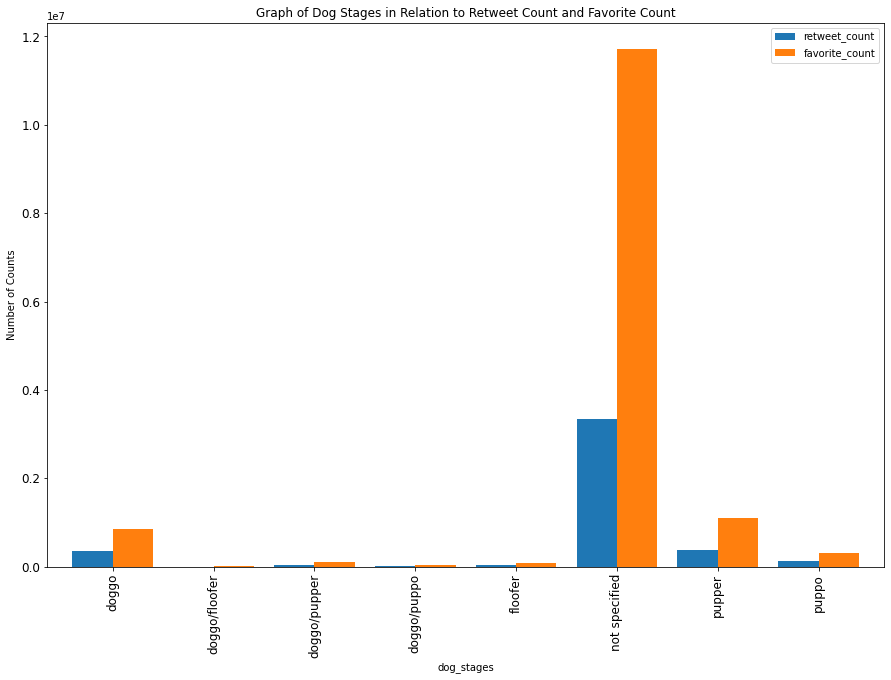

In [100]:
# Plot a bar chart to compare total retweet_count and total favorite_count for the dog_stages
stages_total_count.plot(kind='bar', fontsize=12, width=0.8, figsize=(15,10), ylabel='Number of Counts', title='Graph of Dog Stages in Relation to Retweet Count and Favorite Count')

The graph above shows that dogs whose dog_stages are not specified has the highest favorite and retweet count, which make it not logical to really determine the dog_stage with the highest total retweet count and favorite count. But for the specified, the graph shows that __'pupper'__ has the highest total favorite count and same as the highest retweet count, followed by __'doggo'__, then __'puppo'__ and so on.

<AxesSubplot:title={'center':'Average Rating Numerator for Dog Stages'}, xlabel='dog_stages', ylabel='Average Rating Numerator'>

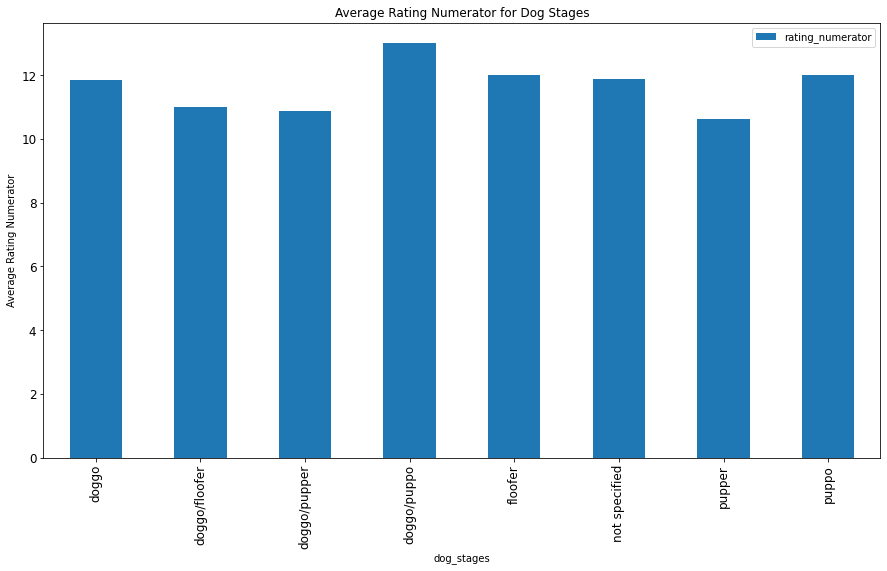

In [101]:
# Graph that shows the distribution of average rating numerator across dog stages
stages_ratings_count.plot(kind='bar', fontsize=12, y='rating_numerator', ylabel='Average Rating Numerator', figsize=(15,8), title='Average Rating Numerator for Dog Stages')

The above chart shows that dog_stage __'doggo/puppo'__ have the highest average rating_numerator while __'pupper'__ has the lowest  rating_numerator.

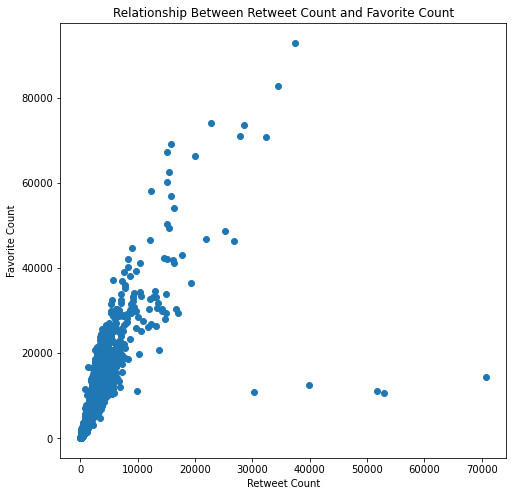

In [102]:
# Scatter plot to show the relationship between retweet_count and favorite_count
plt.figure(figsize=(8,8))
plt.scatter(df_clean.retweet_count, df_clean.favorite_count)
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.title('Relationship Between Retweet Count and Favorite Count')
plt.show()

This shows that there is a positive correlation between retweet count and favorite count, which means a dog with high favorite count will have high retweet count and vice versa.